# Figure 5

This notebook contains the procedures to generate Figure 5, which contains an Admixture bar plot, scatter plots of PCA from genotype data, and the topology of the dendrogram with the populations found with fineStructure

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import os
import glob
from ete3 import Tree, TreeStyle, NodeStyle

## Reading files

We'll set up folders and read files

In [2]:
#Folders
projpath   = os.path.realpath("../..")
pathgeno   = os.path.join(projpath, "DataBases", "Genotypes")
pathgenopc = os.path.join(projpath, "DataBases", "Genotypes", "GenoPCA")
pathadmix  = os.path.join(projpath, "DataBases", "Genotypes", "Admixture")
pathres    = os.path.join(projpath, "Results")
pathfig    = os.path.join(projpath, "Results", "Figures")

In [3]:
#Read files
os.chdir(pathres)
tot_samp = pd.read_csv("tot_samples.csv")
os.chdir(pathgenopc)
geno_pca = pd.read_table("geno.eigenvec", sep=" ", header=None,  usecols=[1,2,3,4,5,6,7,8,9])
geno_pca.columns = ["ID", "geno_PC1", "geno_PC2", "geno_PC3", "geno_PC4", "geno_PC5", "geno_PC6", "geno_PC7", "geno_PC8"]

#Merge files
to_plot = pd.merge(tot_samp, geno_pca, how='left', on=['ID'])

In [4]:
#Read admixture files
os.chdir(pathadmix)
qfiles  = glob.glob("*.Q") #all Q files to read
list_ks = []
for i in qfiles:
    list_ks.append(int(i.split(".")[1])) #Get number of ks per file
    
list_ks = np.array(list_ks) #To np array
sorted_index  = np.argsort(list_ks) #sort and keep indices
qfiles     = [ qfiles[i] for i in sorted_index] #Sort based on indices
admixfiles = []
for i in qfiles:
    file = pd.read_csv(i, sep = " ", header=None)
    admixfiles.append(file)

pop_admix =  pd.read_csv("geno.fam",  sep = " ", header=None)
pop_admix.columns = [0, 'ID', 2, 3, 4, 5]

In [33]:
#Keep only non-reference IDs
#Dividing in reference and not reference samples
adp_bool = pop_admix['ID'].isin(tot_samp['ID'])
adp_ind  = [i for i, x in enumerate(adp_bool) if x]
admix_adapt = []
for i in range(len(admixfiles)):
    #For adapt samples
    new_adapt = admixfiles[i].loc[adp_ind,:].reset_index(drop=True)
    admix_adapt.append(new_adapt)
    
adp_ids = pop_admix['ID'][adp_ind]
    
#Create popfile with initial, and final clustering
popfile = pd.merge(pd.DataFrame(adp_ids), tot_samp[['ID','cluster_initial', 'cluster_final']], on = 'ID')
popfile.columns = ['ID', 'pop', 'super_pop']

#Change popname
for i in range(1,12):
    new_name = 'L' + str(i)
    popfile['pop'][popfile['pop'] == i ] = new_name
    if i < 4:
        new_name = 'B' + str(i)
        popfile['super_pop'][popfile['super_pop'] == i ] = new_name

/home/tomas/anaconda3/envs/main_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/tomas/anaconda3/envs/main_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Plot

We'll generate the plots.
For the colors, we will generate a sequence of 11 custom colors, reflecting the topology of the dendrogram

### Tree

In [16]:
#Topology 
tree_top = Tree("( (L11,((L10,L9),(L8,(L7,L6)))), ( (L5,L4),(L3,(L2,L1))) );")
tree_top.force_topology = True
print(tree_top)


      /-L11
     |
   /-|      /-L10
  |  |   /-|
  |  |  |   \-L9
  |   \-|
  |     |   /-L8
  |      \-|
--|        |   /-L7
  |         \-|
  |            \-L6
  |
  |      /-L5
  |   /-|
  |  |   \-L4
   \-|
     |   /-L3
      \-|
        |   /-L2
         \-|
            \-L1


In [7]:
#Creating list of colors
rgb_values = [(57, 59, 121), (82, 84, 163), (107, 110, 207), (132, 134, 222), (156, 158, 247), 
              (99, 121, 57), (140, 162, 82), (181, 207, 107), (206, 219, 156), (222, 244, 182),
              (140, 109, 49)]
rgb_code   = ['#%02x%02x%02x' % x for x in rgb_values]

In [58]:
#Customizing tree
ts = TreeStyle()

#Rotating, removing scale and general tree settings
ts.show_leaf_name = True
ts.show_scale = False
ts.branch_vertical_margin = 20
ts.rotation = 0

#Remove node points for all, widen lines, and color them gray
for n in tree_top.traverse():
    style = NodeStyle()
    style["vt_line_color"] = "#bbbbbb"
    style["hz_line_color"] = "#bbbbbb"
    style["vt_line_width"] = 4
    style["hz_line_width"] = 4
    style["size"]  = 0
    n.img_style = style

#Color leaves based on leaf
count = 0
for leaf in tree_top.iter_leaves():
    col   = rgb_code[10 - count]
    style = NodeStyle()
    style["vt_line_color"] = col
    style["hz_line_color"] = col
    style["vt_line_width"] = 4
    style["hz_line_width"] = 4
    style["size"]  = 0
    leaf.img_style = style
    count = count + 1

os.chdir(pathfig)
tree_top.render("Tree.png", dpi=300, tree_style=ts, h = 2000, w = 1000)
; #to hide the output

'#to hide the output'

### Admixture

In [68]:
#Definition of set of functions
#First, organize figure in terms of number of Qfiles. 
#Then, for each Qfile, create its corresponding axis, already sorted 
#Try to keep only one sorting options across ks
#Finally, add text to figures

def sort_qfile(Qfile_unsorted):
    #Function to sort Qfiles
    #If pop column exist, then sort first by pop, and super_pop, and then by ks. This will also return the position of pop and super pop labels
    #If pop column does not exist, then sort only by ks
    import pandas as pd
    import numpy as np
    
    Qfile_sorted       = pd.DataFrame()
    Qfile_sort_indices = pd.Series()
    
    if 'pop' in Qfile_unsorted.columns:
        sortpops = ['super_pop', 'pop']
        Qfile_sorted_initial = Qfile_unsorted.sort_values(by = sortpops)
        list_superpop = Qfile_sorted_initial['super_pop'].unique()
        list_pop      = Qfile_sorted_initial['pop'].unique()
        loc_superpop  = []
        loc_pop       = []
        for l in list_superpop:
            #Getting location of superpop with respect to data
            pop_bool = Qfile_sorted_initial['super_pop'] == l
            pop_ind  = [i for i, x in enumerate(pop_bool) if x]
            loc_lab  = ( min(pop_ind) + max(pop_ind) ) / 2
            loc_superpop.append(loc_lab)
        for l in list_pop:
            #Getting location of pop with respect to data
            pop_bool = Qfile_sorted_initial['pop'] == l
            pop_ind  = [i for i, x in enumerate(pop_bool) if x]
            loc_lab  = ( min(pop_ind) + max(pop_ind) ) / 2
            loc_pop.append(loc_lab)
                  
            #Sorting each pop by highest k, and then the remaining ones
            group      = Qfile_sorted_initial.iloc[pop_ind,:]
            sortingby  = [i[0] for i in sorted(enumerate(group.mean()), reverse=True, key=lambda x:x[1])] #Sort by most to least relevant cluster
            indices    = pd.Series(group.sort_values(by = sortingby).index)
            group      = group.sort_values(by = sortingby).reset_index(drop=True)
            Qfile_sorted = pd.concat([Qfile_sorted, group])
            Qfile_sort_indices = Qfile_sort_indices.append(indices)
            
        return(Qfile_sorted, Qfile_sort_indices, loc_superpop, loc_pop, list_superpop, list_pop)
    
    elif 'pop' not in Qfile_unsorted.columns:
        ks = Qfile_unsorted.shape[1] #Number of groups
        cols_to_group = Qfile_unsorted.idxmax(axis=1) #Create list of column with highest value per row
        for i in range(ks):
            #Sorting individuals by separating them in their k with highest proportion, and sorting by the other ks next
            #We'll paste them together to create a new sorted dataframe
            group      = Qfile_unsorted[cols_to_group == i]
            sortingby  = [i[0] for i in sorted(enumerate(group.mean()), reverse=True, key=lambda x:x[1])] #Sort by most to least relevant cluster
            indices    = pd.Series(group.sort_values(by = sortingby).index)
            group      = group.sort_values(by = sortingby).reset_index(drop=True)
            Qfile_sorted = pd.concat([Qfile_sorted, group])
            Qfile_sort_indices = Qfile_sort_indices.append(indices)
        
        return(Qfile_sorted, Qfile_sort_indices)
        
def plot_admix(Qfiles, popfile=None, sort_by_k = None):
    # Figure to plot admixture files
    # Qfiles can be either a list of pandas Dataframes containing the Q proportions
    # or a single file
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    width = 1
    fontsize_k  = 10
    fontsize_up = 15
    fontsize_lo = 12
    
    if isinstance(Qfiles, list): #if there is a list of pandas dataframes
        qs     = len(Qfiles)
        fig    = plt.figure(figsize=(20, 1*qs), dpi=300)
        loc_ks = 1/qs/2
        #Doing sorting in here, keep the same sort across ks
        if popfile is not None:
            #Sort samples based on known populations and ks from last list
            Qfile = pd.concat([Qfiles[qs-1], popfile], axis = 1)
            Qfile_sorted, Qfile_sort_indices, loc_superpop, loc_pop, list_superpop, list_pop = sort_qfile(Qfile)
        if popfile is None:
            if sort_by_k is None:
                sort_by_k = qs - 1                   
            Qfile_sorted, Qfile_sort_indices = sort_qfile(Qfiles[sort_by_k])
            
        for i in range(qs):
            Qfile = Qfiles[i].loc[Qfile_sort_indices,:]
            ks    = Qfile.shape[1]
            ind   = np.arange(Qfile.shape[0]) #Number of samples
            ax    = fig.add_subplot(qs, 1, i+1)
            for l in range(ks):
                this_stack = Qfile[l]
                if l > 0:
                    bottom_stack = Qfile.iloc[:,0:l].sum(axis=1)
                else:
                    bottom_stack = None
                ax.bar(ind, this_stack, bottom = bottom_stack,width = width) 
                plt.axis('off')
                ax.autoscale(tight=True)
            if i == 0 and popfile is not None:
                #if first plot, draw the super_pop legends
                for l in range(len(loc_superpop)):
                    plt.text(loc_superpop[l], 1.2, list_superpop[l], fontsize = fontsize_up)
            if i == (qs-1) and popfile is not None:
                for l in range(len(loc_pop)):
                    plt.text(loc_pop[l], -0.2, list_pop[l], fontsize = fontsize_lo, rotation=90)
            
            #Annotating number of ks
            trans = ax.get_yaxis_transform() # x in data untis, y in axes fraction
            k_text = "k=" + str(ks)
            ann   = ax.annotate(k_text, xy=(-0.03, 0.4 ), xycoords=trans, fontsize= fontsize_k)
                    
    else:
        if popfile is not None:
            #Sort samples based on known populations and ks from last list
            Qfile = pd.concat([Qfiles, popfile], axis = 1)
            Qfile_sorted, Qfile_sort_indices, loc_superpop, loc_pop, list_superpop, list_pop = sort_qfile(Qfile)
        if popfile is None:
            Qfile_sorted, Qfile_sort_indices = sort_qfile(Qfiles)
       
        Qfile = Qfiles.loc[Qfile_sort_indices,:]
        fig   = plt.figure(figsize=(20, 1), dpi=300)
        ks    = Qfile.shape[1]
        ind   = np.arange(Qfile.shape[0]) #Number of samples
        ax    = fig.add_subplot(111)
        for i in range(ks):
            this_stack = Qfile[i]
            if i > 0:
                bottom_stack = Qfile.iloc[:,0:i].sum(axis=1)
            else:
                bottom_stack = None
            ax.bar(ind, this_stack, bottom = bottom_stack,width = width)
            plt.axis('off')
        
        #Annotating number of ks
        trans = ax.get_yaxis_transform() # x in data untis, y in axes fraction
        k_text = "k=" + str(ks)
        ann   = ax.annotate(k_text, xy=(-0.03, 0.4 ), xycoords=trans, fontsize=fontsize_k)
        if popfile is not None:
            for i in range(len(loc_superpop)):
                plt.text(loc_superpop[i], 1.2, list_superpop[i], fontsize=fontsize_up)
            for i in range(len(loc_pop)):
                plt.text(loc_pop[i], -0.2, list_pop[i], fontsize=fontsize_lo, rotation=90)    
        
    #plt.subplots_adjust(left=0.12)
    
    plt.savefig("AdmixPlot.png", dpi = 300, bbox_inches='tight')
    #return(fig, Qfile_sort_indices)

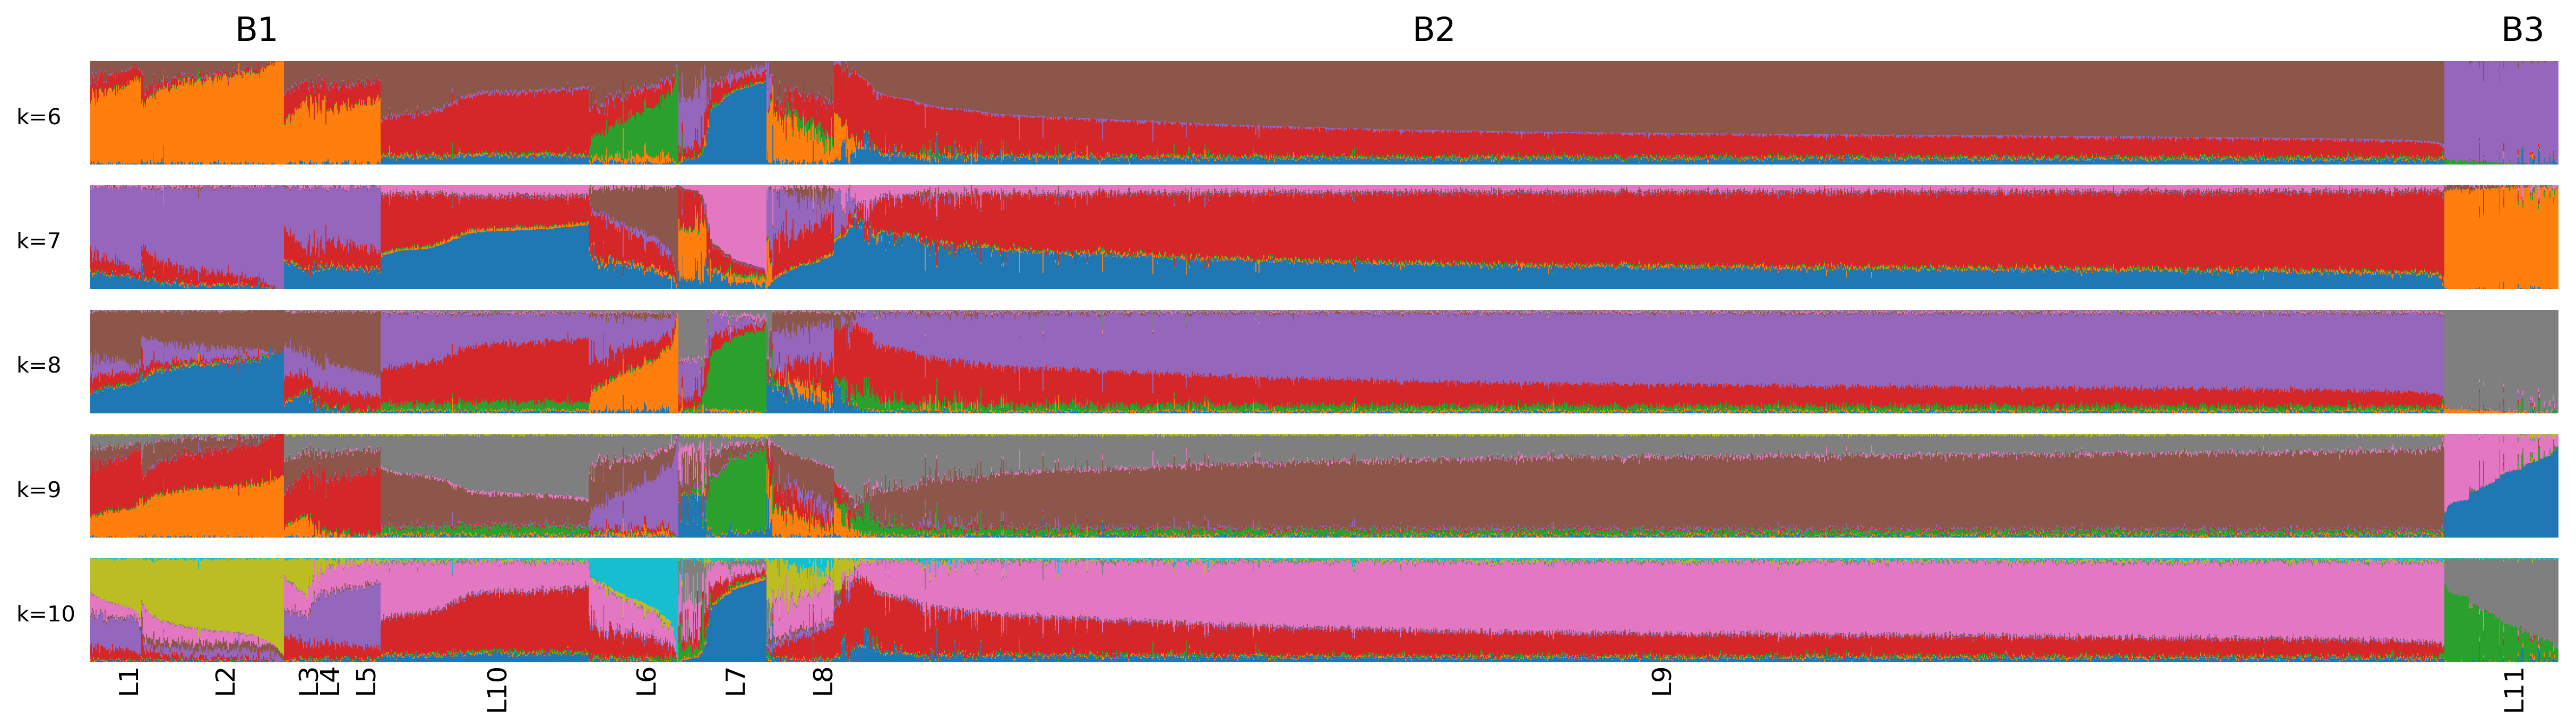

In [69]:
os.chdir(pathfig)
plot_admix(admix_adapt[4:9], popfile=popfile[['pop', 'super_pop']])

### Final plot

In [70]:
#Read plot images
os.chdir(pathfig)
tree_img  = mpimg.imread('Tree.png')
admix_img = mpimg.imread('AdmixPlot.png')

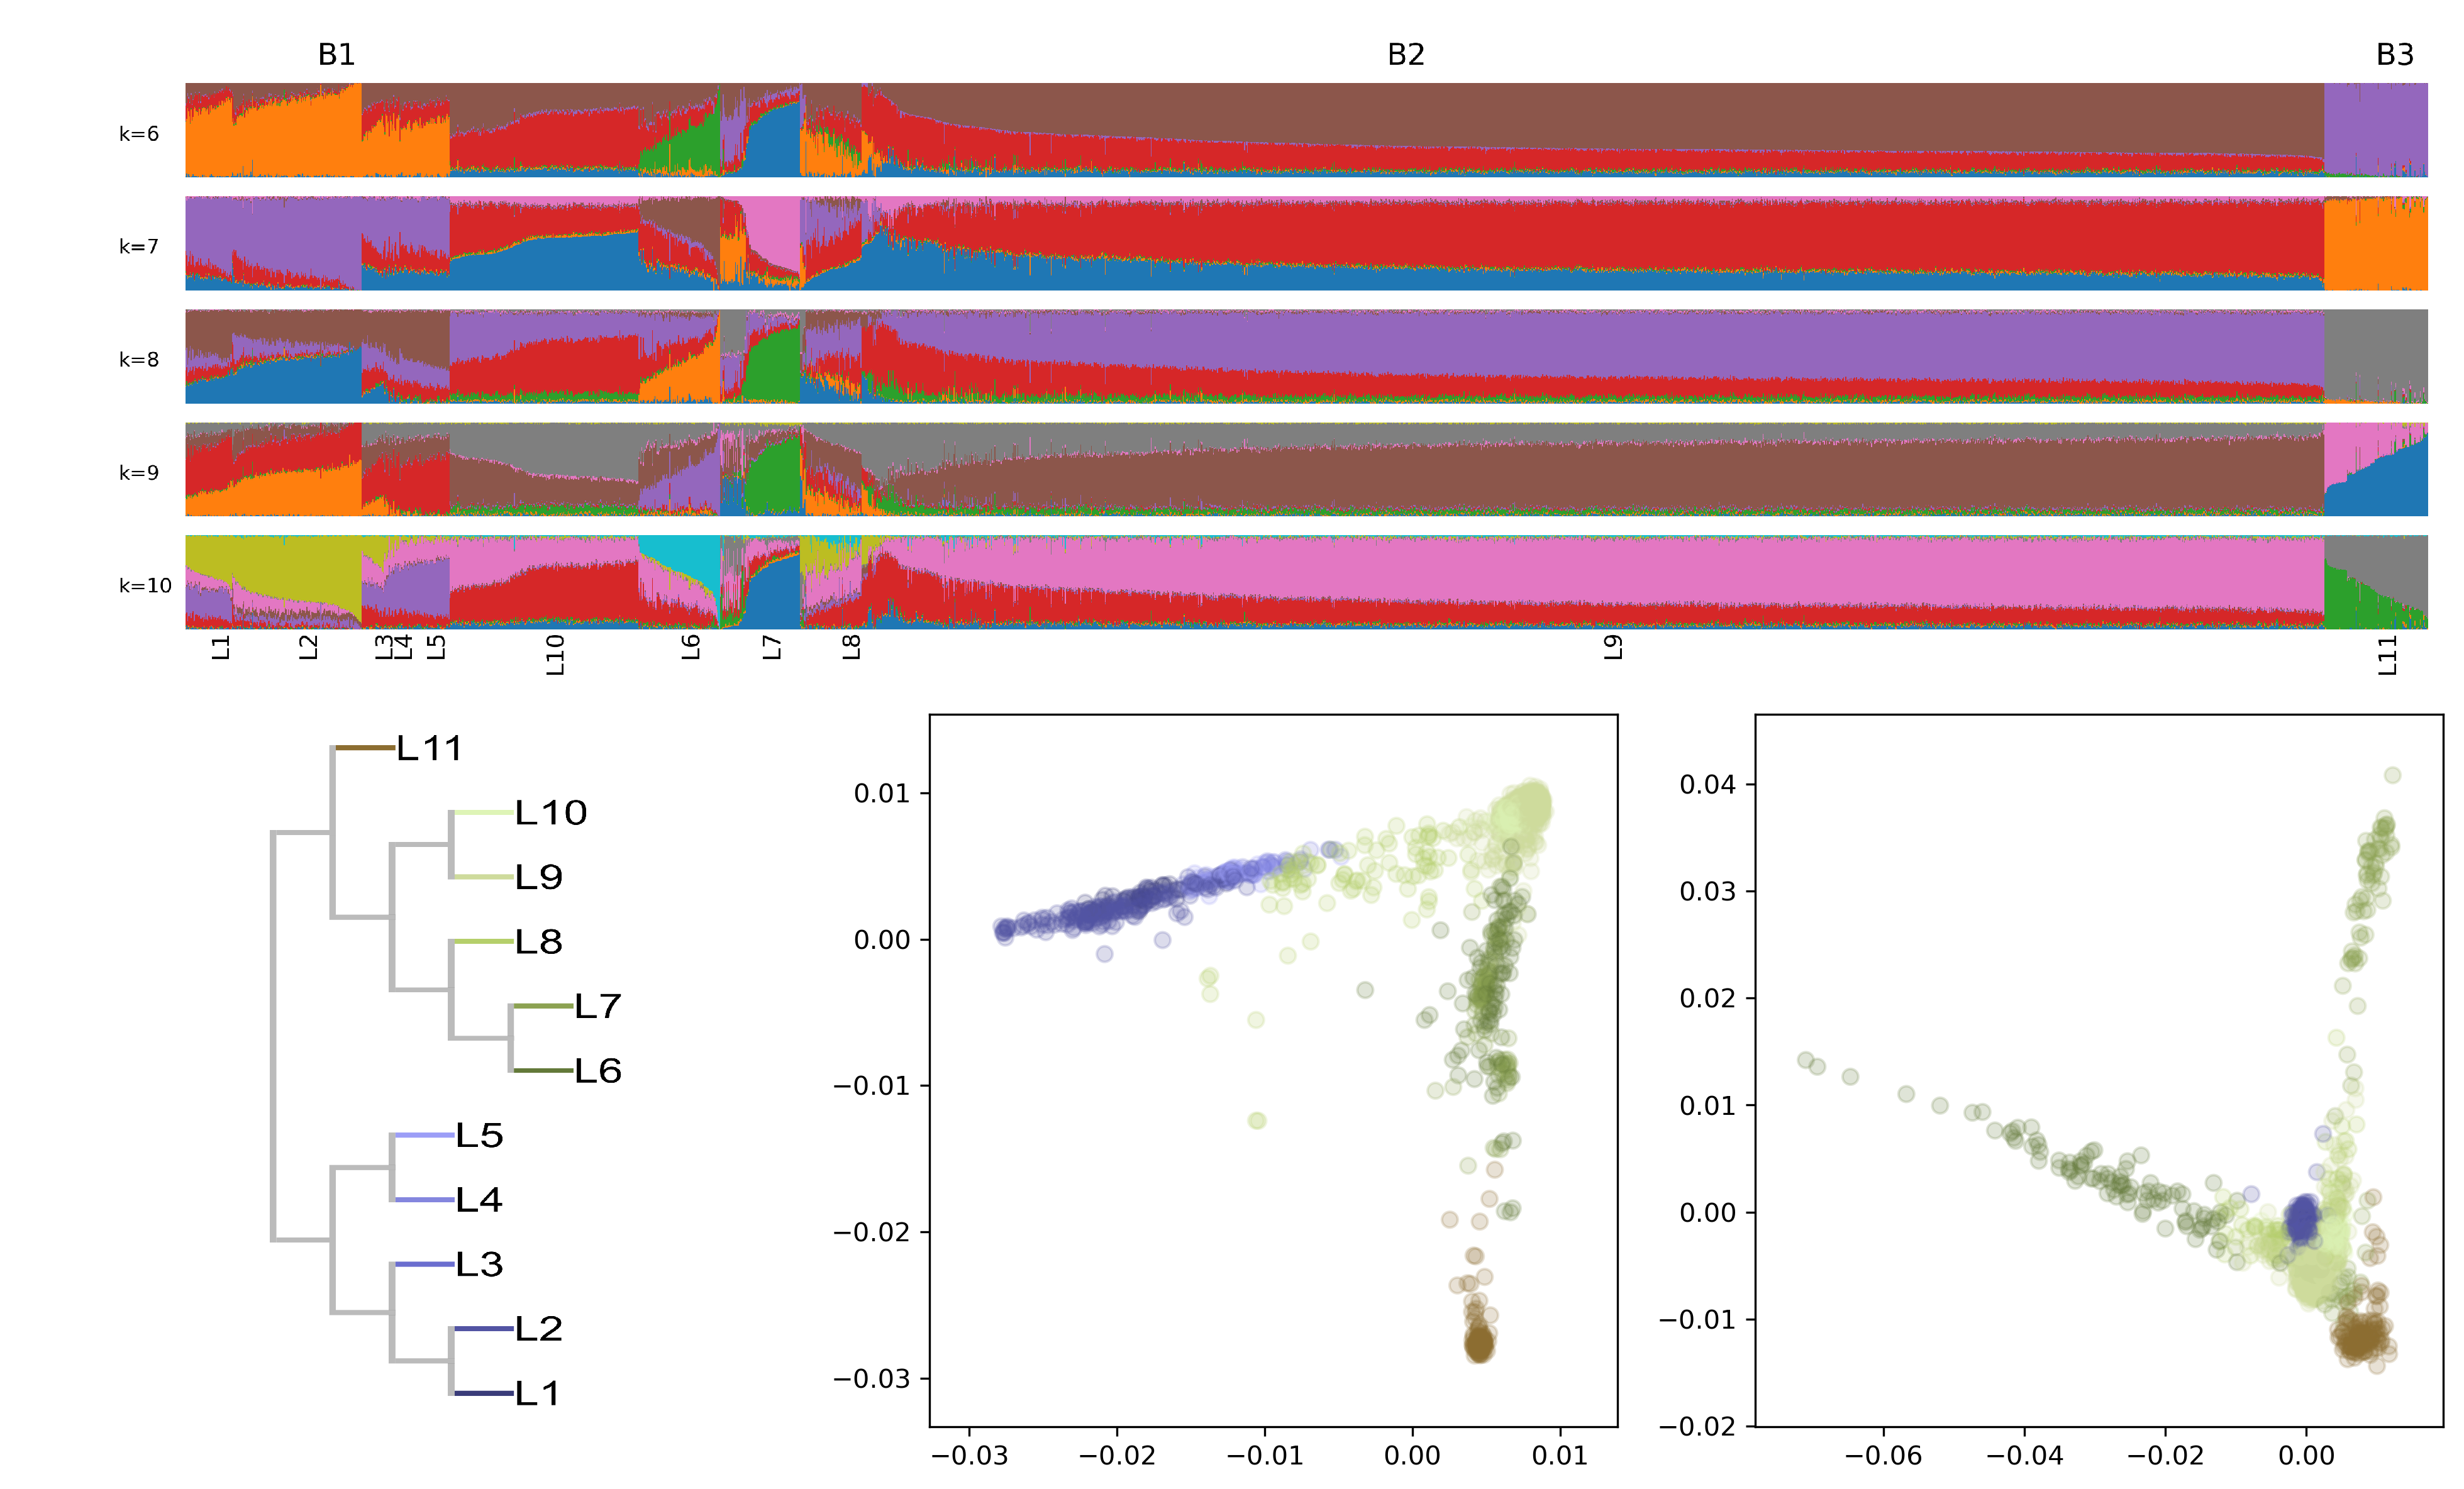

In [84]:
#Generate figure and axes
fig = plt.figure(figsize=(16, 10), dpi=300)
gs  = gridspec.GridSpec(2, 3, hspace = 0)

ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[1,1])
ax3 = fig.add_subplot(gs[1,2])
ax4 = fig.add_subplot(gs[0,:])

#Set up colors
#For initial cluster
#Manual color
color_labels = list(range(1,12))
color_map    = dict(zip(color_labels, rgb_code))

#Generate axes
ax1.imshow(tree_img)
ax1.axis('off')
ax2.scatter(to_plot['geno_PC1'], to_plot['geno_PC2'], c=to_plot['cluster_initial'].map(color_map), alpha=0.2)
ax3.scatter(to_plot['geno_PC3'], to_plot['geno_PC4'], c=to_plot['cluster_initial'].map(color_map), alpha=0.2)
ax4.imshow(admix_img)
ax4.axis('off')

plt.savefig("Figure3.png", dpi=300)
plt.show()